# Creating Content-Based Training Pairs for SBERT Fine-tuning

This notebook creates positive and negative pairs focusing on job description rather than matching job titles for negative and positive paring.


Key Improvements
1. Positive pairs focus on CONTENT similarity (skills + duties + requirements)
2. TF-IDF used to measure content similarity (not just embeddings)
3. Skill category overlap ensures domain relevance
4. Hard negatives have similar keywords but different skill requirements

In [16]:
# Fix for TensorFlow compatibility issues
import os
os.environ['USE_TF'] = '0'
os.environ['USE_TORCH'] = '1'

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from tqdm import tqdm
from collections import defaultdict

random.seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Job Description Data

In [17]:
# Load cleaned job descriptions
jd_df = pd.read_excel("../1_data_cleaning/filtered_jd_sections2.xlsx")
print(f"Loaded {len(jd_df)} job descriptions")
print(f"Columns: {jd_df.columns.tolist()}")
print("\nSample data:")
print(jd_df.head(2))

Loaded 1231 job descriptions
Columns: ['job_description', 'location_cleaned', 'job_title', 'jd_duties', 'jd_requirements', 'jd_education']

Sample data:
                                     job_description location_cleaned  \
0  Job SummaryDo you have a strong aptitude for w...       Natick, MA   
1  Overview External: Chevron is one of the world...      Houston, TX   

                                      job_title  \
0  Content Developer for MATLAB Code Generation   
1                                Land Assistant   

                                           jd_duties  \
0  Software components make up an ever larger par...   
1  Overview External: Chevron is one of the world...   

                                     jd_requirements  \
0  Job SummaryDo you have a strong aptitude for w...   
1  Prepare, and secure appropriate approvals for ...   

                                        jd_education  
0  Minimum Qualifications A bachelor's degree and...  
1        Preferred Qualif

## 2. Enhanced Feature Extraction

Extract more granular features from job descriptions

In [18]:
# Comprehensive skill keywords organized by category
skill_categories = {
    'programming': ['python', 'java', 'javascript', 'c\\+\\+', 'c#', r'\br\b', 'ruby', 'php', 'swift', 'kotlin', 'go', 'rust'],
    'data_science': ['machine learning', 'deep learning', 'nlp', 'data analysis', 'statistics', 'tensorflow', 'pytorch', 'scikit-learn', 'pandas', 'numpy'],
    'cloud': ['aws', 'azure', 'gcp', 'cloud', 'docker', 'kubernetes', 'terraform'],
    'database': ['sql', 'mysql', 'postgresql', 'mongodb', 'nosql', 'database', 'oracle', 'redis'],
    'web': ['html', 'css', 'react', 'angular', 'vue', 'node', 'django', 'flask'],
    'business': ['project management', 'agile', 'scrum', 'leadership', 'communication', 'sales', 'marketing'],
    'finance': ['accounting', 'finance', 'excel', 'financial analysis', 'budgeting', 'forecasting'],
    'healthcare': ['nursing', 'medical', 'patient care', 'healthcare', 'clinical'],
    'engineering': ['engineering', 'design', 'matlab', 'simulink', 'cad', 'solidworks'],
    'legal': ['legal', 'attorney', 'paralegal', 'contract', 'compliance']
}

# Flatten all skills
all_skills = [skill for skills in skill_categories.values() for skill in skills]

def extract_skills(text):
    """Extract skills from text with category information"""
    if pd.isna(text):
        return []
    text_lower = text.lower()
    found_skills = []
    for skill in all_skills:
        if re.search(skill, text_lower):
            found_skills.append(skill.replace('\\b', '').replace('\\+', '+'))
    return found_skills

def get_skill_category(skill):
    """Get category for a skill"""
    for category, skills in skill_categories.items():
        if skill in skills or skill.replace('+', '\\+') in skills:
            return category
    return 'other'

# Extract features
print("Extracting skills from job descriptions...")
jd_df['skills'] = jd_df['job_description'].fillna('').apply(extract_skills)
jd_df['num_skills'] = jd_df['skills'].apply(len)

# Get skill categories for each job
jd_df['skill_categories'] = jd_df['skills'].apply(
    lambda skills: list(set([get_skill_category(s) for s in skills]))
)

print(f"\nSkills extracted: {jd_df['num_skills'].sum()} total, {jd_df['num_skills'].mean():.2f} avg per job")

Extracting skills from job descriptions...

Skills extracted: 6676 total, 5.42 avg per job


## 3. Content Similarity Using TF-IDF

Focus on actual job content (duties + requirements) rather than titles

In [19]:
# Create content-focused text (emphasize duties and requirements)
jd_df['content_text'] = (
    jd_df['jd_duties'].fillna('') + ' ' + 
    jd_df['jd_requirements'].fillna('') + ' ' +
    jd_df['jd_duties'].fillna('') + ' ' +  # Repeat duties for more weight
    jd_df['jd_requirements'].fillna('')      # Repeat requirements for more weight
)

# Create full text including title (for completeness)
jd_df['full_text'] = (
    'Job Title: ' + jd_df['job_title'].fillna('') + '. ' +
    'Description: ' + jd_df['job_description'].fillna('') + '. ' +
    'Duties: ' + jd_df['jd_duties'].fillna('') + '. ' +
    'Requirements: ' + jd_df['jd_requirements'].fillna('') + '. ' +
    'Education: ' + jd_df['jd_education'].fillna('')
)

print("Computing TF-IDF on job content (duties + requirements)...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2),  # Include bigrams
    min_df=2,
    max_df=0.8
)

tfidf_matrix = tfidf_vectorizer.fit_transform(jd_df['content_text'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Compute content similarity matrix
print("Computing content similarity matrix...")
content_similarity_matrix = cosine_similarity(tfidf_matrix)
print(f"Content similarity matrix shape: {content_similarity_matrix.shape}")

Computing TF-IDF on job content (duties + requirements)...
TF-IDF matrix shape: (1231, 500)
Computing content similarity matrix...
Content similarity matrix shape: (1231, 1231)


## 4. Compute Semantic Embeddings (Base Model)

Get initial embeddings for comparison

In [20]:
# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all job descriptions
print("Encoding job descriptions with base model...")
embeddings = model.encode(jd_df['full_text'].tolist(), show_progress_bar=True, batch_size=32)
semantic_similarity_matrix = cosine_similarity(embeddings)

print(f"\nSemantic embedding shape: {embeddings.shape}")

Encoding job descriptions with base model...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]


Semantic embedding shape: (1231, 384)


## 5. Create Content-Based Positive Pairs


In [21]:
def calculate_skill_overlap(skills1, skills2):
    """Calculate Jaccard similarity between skill sets"""
    if not skills1 or not skills2:
        return 0.0
    intersection = len(set(skills1) & set(skills2))
    union = len(set(skills1) | set(skills2))
    return intersection / union if union > 0 else 0.0

def calculate_category_overlap(cats1, cats2):
    """Calculate overlap in skill categories"""
    if not cats1 or not cats2:
        return 0.0
    intersection = len(set(cats1) & set(cats2))
    union = len(set(cats1) | set(cats2))
    return intersection / union if union > 0 else 0.0

def create_content_based_positive_pairs(num_pairs=3000):
    """
    Create positive pairs based on CONTENT similarity, not title similarity
    
    Criteria for positive pairs:
    1. High skill overlap (>= 0.4)
    2. High content similarity (>= 0.5)
    3. Overlapping skill categories
    4. Title similarity is IGNORED (allows cross-domain matching)
    """
    positive_pairs = []
    seen_pairs = set()
    
    print("Creating content-based positive pairs...")
    
    for i in tqdm(range(len(jd_df))):
        # Get content similarities for this job
        content_sims = content_similarity_matrix[i]
        
        # Find candidates with high content similarity
        candidate_indices = np.where(content_sims > 0.5)[0]
        
        for j in candidate_indices:
            if i >= j:  # Avoid duplicates and self-pairs
                continue
            
            pair_key = (min(i, j), max(i, j))
            if pair_key in seen_pairs:
                continue
            
            # Calculate skill overlap
            skill_overlap = calculate_skill_overlap(
                jd_df.iloc[i]['skills'],
                jd_df.iloc[j]['skills']
            )
            
            # Calculate category overlap
            category_overlap = calculate_category_overlap(
                jd_df.iloc[i]['skill_categories'],
                jd_df.iloc[j]['skill_categories']
            )
            
            # Criteria: high skill overlap and category overlap
            if skill_overlap >= 0.4 and category_overlap >= 0.5:
                positive_pairs.append({
                    'job1_idx': i,
                    'job2_idx': j,
                    'skill_overlap': skill_overlap,
                    'category_overlap': category_overlap,
                    'content_similarity': content_sims[j],
                    'semantic_similarity': semantic_similarity_matrix[i][j],
                    'same_title': int(jd_df.iloc[i]['job_title'].lower() == jd_df.iloc[j]['job_title'].lower())
                })
                seen_pairs.add(pair_key)
                
            if len(positive_pairs) >= num_pairs:
                break
        
        if len(positive_pairs) >= num_pairs:
            break
    
    # If we don't have enough, lower the skill overlap threshold
    if len(positive_pairs) < num_pairs:
        print(f"\nNeed {num_pairs - len(positive_pairs)} more pairs, lowering skill threshold...")
        
        for i in tqdm(range(len(jd_df))):
            content_sims = content_similarity_matrix[i]
            candidate_indices = np.where(content_sims > 0.4)[0]
            
            for j in candidate_indices:
                if i >= j:
                    continue
                
                pair_key = (min(i, j), max(i, j))
                if pair_key in seen_pairs:
                    continue
                
                skill_overlap = calculate_skill_overlap(
                    jd_df.iloc[i]['skills'],
                    jd_df.iloc[j]['skills']
                )
                
                category_overlap = calculate_category_overlap(
                    jd_df.iloc[i]['skill_categories'],
                    jd_df.iloc[j]['skill_categories']
                )
                
                # Lower threshold
                if skill_overlap >= 0.3 and category_overlap >= 0.3:
                    positive_pairs.append({
                        'job1_idx': i,
                        'job2_idx': j,
                        'skill_overlap': skill_overlap,
                        'category_overlap': category_overlap,
                        'content_similarity': content_sims[j],
                        'semantic_similarity': semantic_similarity_matrix[i][j],
                        'same_title': int(jd_df.iloc[i]['job_title'].lower() == jd_df.iloc[j]['job_title'].lower())
                    })
                    seen_pairs.add(pair_key)
                
                if len(positive_pairs) >= num_pairs:
                    break
            
            if len(positive_pairs) >= num_pairs:
                break
    
    return positive_pairs[:num_pairs]

# Generate positive pairs
positive_pairs = create_content_based_positive_pairs(num_pairs=3000)
print(f"\nCreated {len(positive_pairs)} content-based positive pairs")

# Analyze positive pairs
pos_df = pd.DataFrame(positive_pairs)
print(f"\nPositive pairs with different titles: {(pos_df['same_title']==0).sum()} ({(pos_df['same_title']==0).sum()/len(pos_df)*100:.1f}%)")
print(f"Average skill overlap: {pos_df['skill_overlap'].mean():.3f}")
print(f"Average content similarity: {pos_df['content_similarity'].mean():.3f}")

Creating content-based positive pairs...


100%|██████████| 1231/1231 [00:00<00:00, 5403.03it/s]



Need 1936 more pairs, lowering skill threshold...


 60%|█████▉    | 734/1231 [00:00<00:00, 3053.55it/s]


Created 3000 content-based positive pairs

Positive pairs with different titles: 2850 (95.0%)
Average skill overlap: 0.529
Average content similarity: 0.551


## 6. Create Hard Negative Pairs

Focus on jobs that have similar keywords but different skill requirements

In [22]:
def create_content_based_negative_pairs(num_pairs=3000):
    """
    Create hard negative pairs based on content
    
    Criteria for hard negatives:
    1. Moderate content similarity (0.3-0.5) - similar keywords
    2. Los skill overlap (< 0.25) - different actual skills
    3. Different skill categories
    
    Example: Both mention "analysis" but one is data analysis, other is financial analysis
    """
    negative_pairs = []
    seen_pairs = set()
    
    print("Creating content-based hard negative pairs...")
    
    for i in tqdm(range(len(jd_df))):
        content_sims = content_similarity_matrix[i]
        
        # Find candidates with moderate content similarity
        candidate_indices = np.where((content_sims > 0.3) & (content_sims < 0.5))[0]
        
        for j in candidate_indices:
            if i >= j:
                continue
            
            pair_key = (min(i, j), max(i, j))
            if pair_key in seen_pairs:
                continue
            
            skill_overlap = calculate_skill_overlap(
                jd_df.iloc[i]['skills'],
                jd_df.iloc[j]['skills']
            )
            
            category_overlap = calculate_category_overlap(
                jd_df.iloc[i]['skill_categories'],
                jd_df.iloc[j]['skill_categories']
            )
            
            # Hard negative: similar text but low skill overlap
            if skill_overlap < 0.25 and category_overlap < 0.5:
                negative_pairs.append({
                    'job1_idx': i,
                    'job2_idx': j,
                    'skill_overlap': skill_overlap,
                    'category_overlap': category_overlap,
                    'content_similarity': content_sims[j],
                    'semantic_similarity': semantic_similarity_matrix[i][j],
                    'same_title': int(jd_df.iloc[i]['job_title'].lower() == jd_df.iloc[j]['job_title'].lower())
                })
                seen_pairs.add(pair_key)
            
            if len(negative_pairs) >= num_pairs:
                break
        
        if len(negative_pairs) >= num_pairs:
            break
    
    # If we don't have enough, expand the content similarity range
    if len(negative_pairs) < num_pairs:
        print(f"\nNeed {num_pairs - len(negative_pairs)} more negative pairs, expanding range...")
        
        for i in tqdm(range(len(jd_df))):
            content_sims = content_similarity_matrix[i]
            candidate_indices = np.where((content_sims > 0.25) & (content_sims < 0.6))[0]
            
            for j in candidate_indices:
                if i >= j:
                    continue
                
                pair_key = (min(i, j), max(i, j))
                if pair_key in seen_pairs:
                    continue
                
                skill_overlap = calculate_skill_overlap(
                    jd_df.iloc[i]['skills'],
                    jd_df.iloc[j]['skills']
                )
                
                category_overlap = calculate_category_overlap(
                    jd_df.iloc[i]['skill_categories'],
                    jd_df.iloc[j]['skill_categories']
                )
                
                if skill_overlap < 0.3:
                    negative_pairs.append({
                        'job1_idx': i,
                        'job2_idx': j,
                        'skill_overlap': skill_overlap,
                        'category_overlap': category_overlap,
                        'content_similarity': content_sims[j],
                        'semantic_similarity': semantic_similarity_matrix[i][j],
                        'same_title': int(jd_df.iloc[i]['job_title'].lower() == jd_df.iloc[j]['job_title'].lower())
                    })
                    seen_pairs.add(pair_key)
                
                if len(negative_pairs) >= num_pairs:
                    break
            
            if len(negative_pairs) >= num_pairs:
                break
    
    return negative_pairs[:num_pairs]

# Generate hard negative pairs
negative_pairs = create_content_based_negative_pairs(num_pairs=len(positive_pairs))
print(f"\nCreated {len(negative_pairs)} content-based hard negative pairs")

# Analyze negative pairs
neg_df = pd.DataFrame(negative_pairs)
print(f"\nAverage skill overlap: {neg_df['skill_overlap'].mean():.3f}")
print(f"Average content similarity: {neg_df['content_similarity'].mean():.3f}")

Creating content-based hard negative pairs...


 27%|██▋       | 338/1231 [00:00<00:01, 607.34it/s]


Created 3000 content-based hard negative pairs

Average skill overlap: 0.124
Average content similarity: 0.352


## 7. Create Training Dataset

In [23]:
# Convert to DataFrames
pos_df = pd.DataFrame(positive_pairs)
pos_df['label'] = 1

neg_df = pd.DataFrame(negative_pairs)
neg_df['label'] = 0

# Combine
pairs_df = pd.concat([pos_df, neg_df], ignore_index=True)

# Add job titles and text from the original dataframe
pairs_df['job1_title'] = pairs_df['job1_idx'].apply(lambda idx: jd_df.iloc[idx]['job_title'])
pairs_df['job2_title'] = pairs_df['job2_idx'].apply(lambda idx: jd_df.iloc[idx]['job_title'])
pairs_df['job1_text'] = pairs_df['job1_idx'].apply(lambda idx: jd_df.iloc[idx]['full_text'])
pairs_df['job2_text'] = pairs_df['job2_idx'].apply(lambda idx: jd_df.iloc[idx]['full_text'])

# Shuffle
pairs_df = pairs_df.sample(frac=1, random_state=42).reset_index(drop=True)

## 8. Quality Analysis

POSITIVE PAIRS STATISTICS
       skill_overlap  content_similarity  semantic_similarity  \
count    3000.000000         3000.000000          3000.000000   
mean        0.529027            0.550673             0.551213   
std         0.192114            0.177663             0.190548   
min         0.300000            0.400004             0.098588   
25%         0.384615            0.431370             0.415441   
50%         0.500000            0.481054             0.523574   
75%         0.600000            0.575707             0.655840   
max         1.000000            1.000000             1.000000   

       category_overlap  
count       3000.000000  
mean           0.645082  
std            0.197723  
min            0.333333  
25%            0.500000  
50%            0.600000  
75%            0.750000  
max            1.000000  

NEGATIVE PAIRS STATISTICS
       skill_overlap  content_similarity  semantic_similarity  \
count    3000.000000         3000.000000          3000.000000 

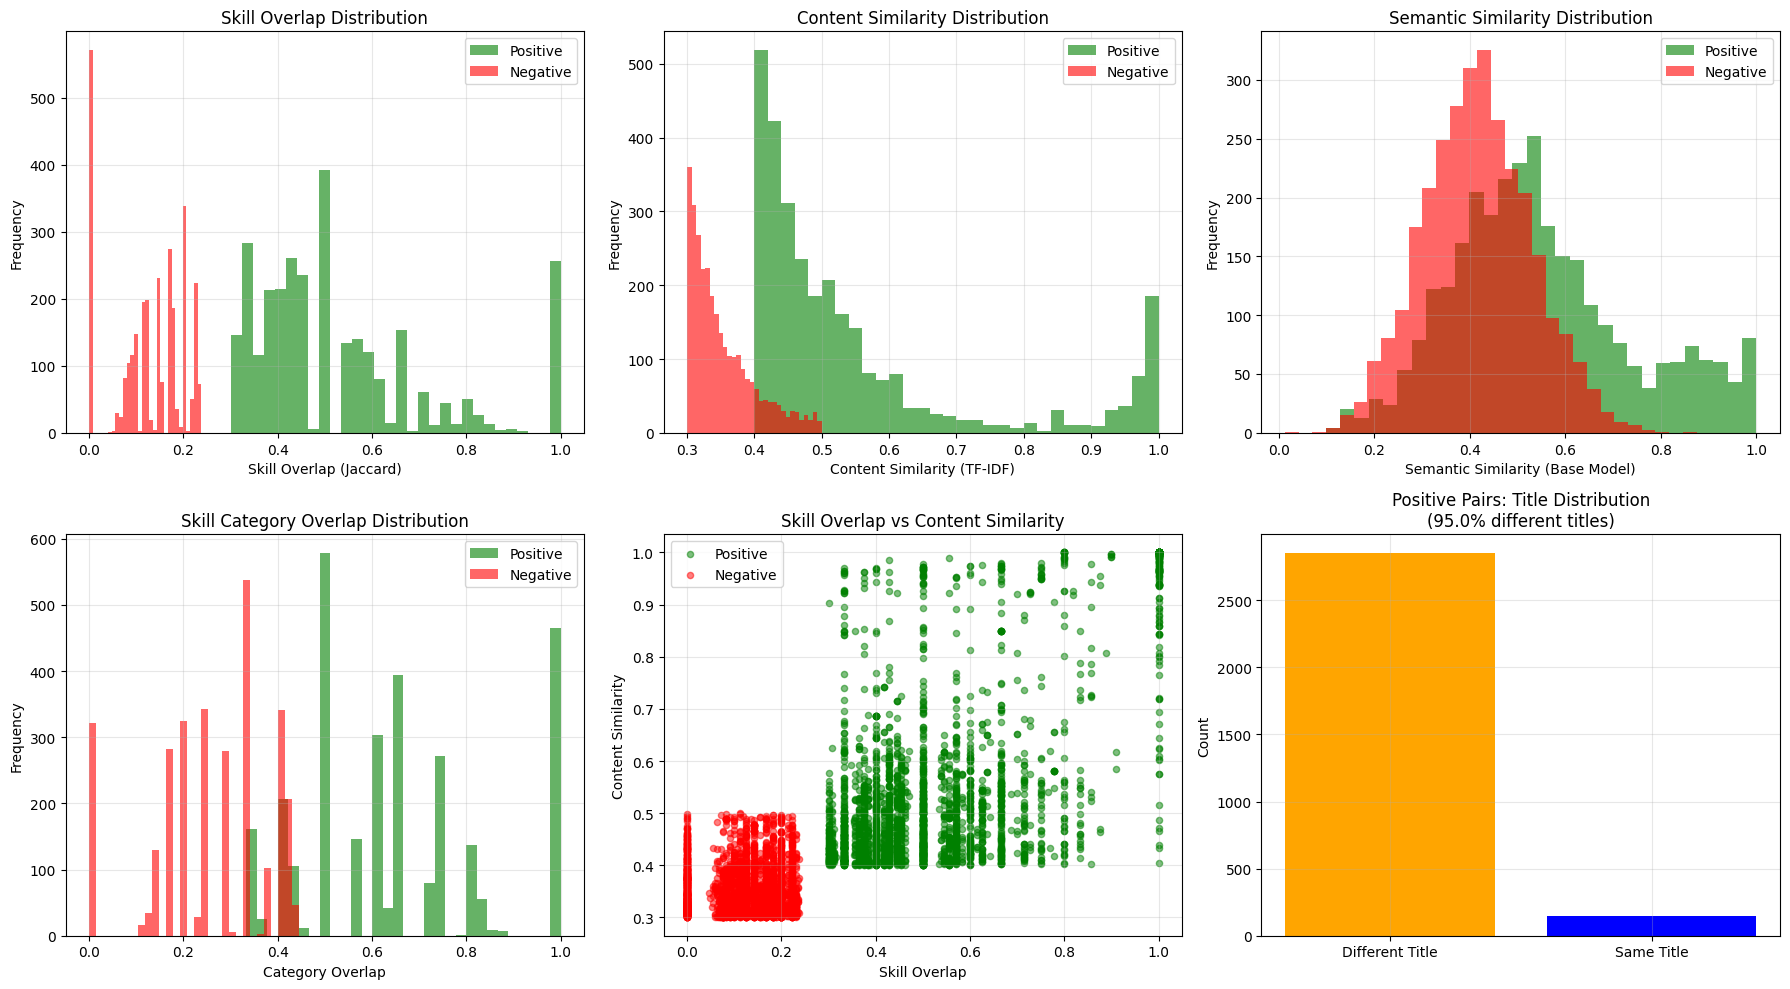


Quality analysis plot saved as 'content_based_pair_quality.png'


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
print("=" * 80)
print("POSITIVE PAIRS STATISTICS")
print("=" * 80)
print(pos_df[['skill_overlap', 'content_similarity', 'semantic_similarity', 'category_overlap']].describe())

print("\n" + "=" * 80)
print("NEGATIVE PAIRS STATISTICS")
print("=" * 80)
print(neg_df[['skill_overlap', 'content_similarity', 'semantic_similarity', 'category_overlap']].describe())

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Skill overlap
axes[0, 0].hist(pos_df['skill_overlap'], bins=30, alpha=0.6, label='Positive', color='green')
axes[0, 0].hist(neg_df['skill_overlap'], bins=30, alpha=0.6, label='Negative', color='red')
axes[0, 0].set_xlabel('Skill Overlap (Jaccard)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Skill Overlap Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Content similarity (TF-IDF)
axes[0, 1].hist(pos_df['content_similarity'], bins=30, alpha=0.6, label='Positive', color='green')
axes[0, 1].hist(neg_df['content_similarity'], bins=30, alpha=0.6, label='Negative', color='red')
axes[0, 1].set_xlabel('Content Similarity (TF-IDF)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Content Similarity Distribution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Semantic similarity
axes[0, 2].hist(pos_df['semantic_similarity'], bins=30, alpha=0.6, label='Positive', color='green')
axes[0, 2].hist(neg_df['semantic_similarity'], bins=30, alpha=0.6, label='Negative', color='red')
axes[0, 2].set_xlabel('Semantic Similarity (Base Model)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Semantic Similarity Distribution')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Category overlap
axes[1, 0].hist(pos_df['category_overlap'], bins=30, alpha=0.6, label='Positive', color='green')
axes[1, 0].hist(neg_df['category_overlap'], bins=30, alpha=0.6, label='Negative', color='red')
axes[1, 0].set_xlabel('Category Overlap')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Skill Category Overlap Distribution')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Scatter: Skill overlap vs Content similarity
axes[1, 1].scatter(pos_df['skill_overlap'], pos_df['content_similarity'], 
                   alpha=0.5, label='Positive', color='green', s=20)
axes[1, 1].scatter(neg_df['skill_overlap'], neg_df['content_similarity'], 
                   alpha=0.5, label='Negative', color='red', s=20)
axes[1, 1].set_xlabel('Skill Overlap')
axes[1, 1].set_ylabel('Content Similarity')
axes[1, 1].set_title('Skill Overlap vs Content Similarity')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Title distribution
pos_same_title = (pos_df['same_title']==1).sum()
pos_diff_title = (pos_df['same_title']==0).sum()
axes[1, 2].bar(['Different Title', 'Same Title'], 
               [pos_diff_title, pos_same_title],
               color=['orange', 'blue'])
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title(f'Positive Pairs: Title Distribution\n({pos_diff_title/len(pos_df)*100:.1f}% different titles)')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('content_based_pair_quality.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nQuality analysis plot saved as 'content_based_pair_quality.png'")

## 9. Show Sample Pairs

In [25]:
# Sample positive pair with DIFFERENT titles
print("=" * 80)
print("SAMPLE POSITIVE PAIR (Similar Content, Different Titles)")
print("=" * 80)
pos_diff_title = pairs_df[(pairs_df['label']==1) & (pairs_df['same_title']==0)].iloc[0] if ((pairs_df['label']==1) & (pairs_df['same_title']==0)).any() else pairs_df[pairs_df['label']==1].iloc[0]
print(f"\nSkill Overlap: {pos_diff_title['skill_overlap']:.3f}")
print(f"Content Similarity: {pos_diff_title['content_similarity']:.3f}")
print(f"Semantic Similarity: {pos_diff_title['semantic_similarity']:.3f}")
print(f"\nJob 1: {pos_diff_title['job1_title']}")
print(f"Text: {pos_diff_title['job1_text'][:300]}...")
print(f"\nJob 2: {pos_diff_title['job2_title']}")
print(f"Text: {pos_diff_title['job2_text'][:300]}...")

# Sample negative pair
print("\n" + "=" * 80)
print("SAMPLE HARD NEGATIVE PAIR (Similar Keywords, Different Skills)")
print("=" * 80)
neg_sample = pairs_df[pairs_df['label']==0].iloc[0]
print(f"\nSkill Overlap: {neg_sample['skill_overlap']:.3f}")
print(f"Content Similarity: {neg_sample['content_similarity']:.3f}")
print(f"Semantic Similarity: {neg_sample['semantic_similarity']:.3f}")
print(f"\nJob 1: {neg_sample['job1_title']}")
print(f"Text: {neg_sample['job1_text'][:300]}...")
print(f"\nJob 2: {neg_sample['job2_title']}")
print(f"Text: {neg_sample['job2_text'][:300]}...")

SAMPLE POSITIVE PAIR (Similar Content, Different Titles)

Skill Overlap: 0.500
Content Similarity: 0.471
Semantic Similarity: 0.488

Job 1: Resident Nurse
Text: Job Title: Resident Nurse. Description: Registered Nurse Medical-SurgicalAdvance your Career!Our client, a well-respected and growing healthcare system, has engaged Parallon Workforce Solutions to secure a permanent Registered Nurse Medical-Surgical. This is an opportunity to join a top facility in ...

Job 2: RN Crestwood Health & Rehab
Text: Job Title: RN Crestwood Health & Rehab. Description: In order to attract and retain our top notch staff, we offer:·         -Career Advancement opportunities·       -  Employee Recognition and Center Based Incentives·         -Educational Assistance up to $2,500/yr·         -Competitive Wages·      ...

SAMPLE HARD NEGATIVE PAIR (Similar Keywords, Different Skills)

Skill Overlap: 0.235
Content Similarity: 0.330
Semantic Similarity: 0.558

Job 1: Sr. Oracle DBA (PPS)
Text: Job Title: Sr. 

## 10. Split into Train/Val/Test Sets

In [26]:
from sklearn.model_selection import train_test_split

# 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(pairs_df, test_size=0.3, random_state=42, stratify=pairs_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

## 11. Save Training Data

In [27]:
# Save to CSV
train_df.to_csv('train_pairs_content_based.csv', index=False)
val_df.to_csv('val_pairs_content_based.csv', index=False)
test_df.to_csv('test_pairs_content_based.csv', index=False)


In [28]:
# KEY IMPROVEMENTS
# 1. Positive pairs focus on CONTENT similarity (skills + duties + requirements)
# 2. TF-IDF used to measure content similarity (not just embeddings)
# 3. Skill category overlap ensures domain relevance
# 4. Hard negatives have similar keywords but different skill requirements